In [1]:
import obspy
from obspy.io.sac.sactrace import SACTrace
from obspy.io.sac.util import get_sac_reftime
import os
import glob

In [6]:
def do_filter(data_dir, freq_low, freq_high, phase):
    """
    filter data
    """
    if not os.path.exists(data_dir):
        print("Missing File: %s" % data_dir)

    for ev in os.listdir(data_dir):
        inpath = os.path.join(data_dir, ev)
        # remove the existed filtered files *.bp
        for bp in glob.glob(f"{inpath}/*.bp*"):
            os.remove(bp)
        
        for sac in os.listdir(inpath):
            insac = os.path.join(inpath, sac)
            st = obspy.read(insac)

            # rmean, rtrend & taper
            st.detrend("demean")
            st.detrend("linear")
            st.taper(max_percentage=0.05, type='hann')
            
            # bandpass
            st.filter('bandpass', freqmin=freq_low, freqmax=freq_high, corners=2, zerophase=phase)
            
            st[0].write(insac +".bp", format='SAC')

In [7]:
def do_resample(data_dir, sample_rate):
    """
    resample data
    """
    if not os.path.exists(data_dir):
        print("Missing File: %s" % data_dir)

    for ev in os.listdir(data_dir):
        inpath = os.path.join(data_dir, ev)
        
        for sac in os.listdir(inpath):
            insac = os.path.join(inpath, sac)
            st = obspy.read(insac)
            
            # resample
            st.resample(sample_rate, no_filter="False")
            
            st[0].write(insac, format='SAC')

In [8]:
def do_alignP(data_dir, time_before, time_after):
    """
    align data according P (the phase has been written in sacheader)
    """
    if not os.path.exists(data_dir):
        print("Missing File: %s" % data_dir)

    for ev in os.listdir(data_dir):
        inpath = os.path.join(data_dir, ev)
        
        for bp in glob.glob(f"{inpath}/*.bp"):
            # align waveform according to P
            sac = SACTrace.read(bp)
            sac._allt(-1*sac.t1)
            sac.write(bp, headonly=True)
            # cut the waveform within a given time window
            tr = obspy.read(bp)
            T = get_sac_reftime(tr[0].stats.sac) + tr[0].stats.sac.t1
            tr.trim(starttime = T+time_before, endtime = T+time_after, fill_value=0)
            tr[0].write(bp +".cut", format='SAC')

In [9]:
# filter data
data_sac = "/home/tianjue/SPMS/NCA/Data/Download/SAC"

do_filter(data_sac, 1.0, 8.0, "TRUE")
do_resample(data_sac, 100)

In [10]:
# cut the waveform within the given time window
do_alignP(data_sac, -5, 20)

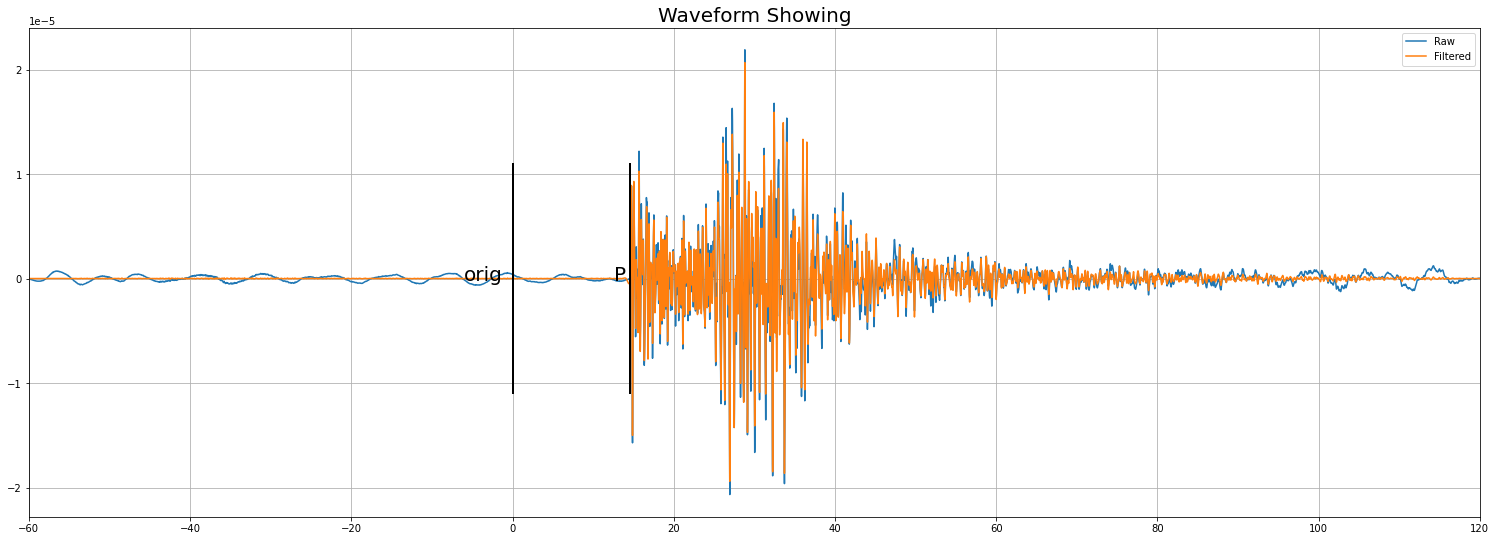

In [11]:
# Quick waveform check
from obspy import read
from obspy.io.sac import SACTrace 
import matplotlib.pyplot as plt
import numpy as np

wtdir="/home/tianjue/SPMS/NCA/Data/Download/SAC"
evt = 20201227040537150
st = read(f"{wtdir}/{evt}/CI.CCC..BHZ.SAC")

st2 = read(f"{wtdir}/{evt}/CI.CCC..BHZ.SAC.bp")

d1 = st[0].data
d1 -= d1[0]

d2 = st2[0].data
d2 -= d2[0]

sac = SACTrace.read(f"{wtdir}/{evt}/CI.CCC..BHZ.SAC")

t = np.arange(0+sac.b, st[0].stats.npts / st[0].stats.sampling_rate+sac.b, st[0].stats.delta)
t2 = np.arange(0+sac.b, st2[0].stats.npts / st2[0].stats.sampling_rate+sac.b, st2[0].stats.delta)

plt.figure(figsize=(26,9))
plt.plot(t,d1,label="Raw")
plt.plot(t,d2,label="Filtered")
#origin time
plt.plot([sac.o, sac.o], [-1*max(d1)*0.5, max(d1)*0.5], color="black", linewidth=2)
plt.text(sac.o-6, -1*max(d1)*0.01, 'orig', fontsize=20)
#first-P arrival
plt.plot([sac.t1, sac.t1], [-1*max(d1)*0.5, max(d1)*0.5], color="black", linewidth=2)
plt.text(sac.t1-2, -1*max(d1)*0.01, 'P', fontsize=20)
plt.xlim(-60, 120)
plt.legend()
plt.title('Waveform Showing', fontsize=20)
plt.grid()

plt.show()